# Part 2 - Tuning Dropout Layers

In [25]:
import os
import shutil
from sklearn.model_selection import train_test_split


In [26]:
base_dir = os.getcwd()
base_dir

'/kaggle/working'

In [27]:
# Path to the Kaggle input directory
input_dir = '/kaggle/input/samuelsfoodlist/Samuels Food List'
input_dir

'/kaggle/input/samuelsfoodlist/Samuels Food List'

In [28]:
train_dir = os.path.join(input_dir, 'train')
train_dir

'/kaggle/input/samuelsfoodlist/Samuels Food List/train'

In [29]:
validation_dir = os.path.join(input_dir, 'validation')
validation_dir

'/kaggle/input/samuelsfoodlist/Samuels Food List/validation'

In [30]:
test_dir = os.path.join(input_dir, 'test')
test_dir

'/kaggle/input/samuelsfoodlist/Samuels Food List/test'

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size=150

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 50x50
        target_size=(img_size, img_size),
        batch_size=32,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical'
    )

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [32]:
from tensorflow import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
#print('Keras version:', tf.keras.__version__)
!nvidia-smi

TensorFlow version: 2.13.0
Tue Dec  5 12:29:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    35W / 250W |  15781MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotFromHistory(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
def trainWithEpochsEarlyStopping(model, epochs=80, patience=10):
    # Create an EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Train the model with early stopping
    history = model.fit(
        train_generator,
        steps_per_epoch=235,  # train_sample_size/data_batch_size
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=63,
        callbacks=[early_stopping]
    )
    return history

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size = 150

def create_data_generators(batch_size=32):
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    # No data augmentation for validation and test sets
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Training data generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Validation data generator
    validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Test data generator
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, validation_generator, test_generator


In [34]:
train_generator, validation_generator, test_generator = create_data_generators(batch_size=32)

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras.layers import ZeroPadding2D, Dropout
from tensorflow.keras import optimizers

img_size = 150

model15_8 = models.Sequential()

model15_8.add(layers.Conv2D(64, (3, 3), activation='relu', 
                           input_shape=(img_size, img_size, 3),  kernel_regularizer=regularizers.l2(0.008)))
model15_8.add(layers.BatchNormalization())
model15_8.add(layers.Conv2D(64, (3, 3), activation='relu', 
                           input_shape=(img_size, img_size, 3), kernel_regularizer=regularizers.l2(0.008)))
model15_8.add(layers.BatchNormalization())
model15_8.add(layers.MaxPooling2D((2, 2)))
#model15_8.add(Dropout(0.2))  # Add dropout layer

model15_8.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model15_8.add(layers.BatchNormalization())
model15_8.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model15_8.add(layers.BatchNormalization())
model15_8.add(layers.MaxPooling2D((2, 2)))
#model15_8.add(Dropout(0.2))  # Add dropout layer

model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
model15_8.add(layers.BatchNormalization())
model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
model15_8.add(layers.BatchNormalization())
model15_8.add(layers.MaxPooling2D((2, 2)))
#model15_8.add(Dropout(0.2))  # Add dropout layer

model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
model15_8.add(layers.BatchNormalization())
model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
model15_8.add(layers.BatchNormalization())
model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
model15_8.add(layers.BatchNormalization())
model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
model15_8.add(layers.BatchNormalization())
model15_8.add(layers.MaxPooling2D((2, 2)))
model15_8.add(Dropout(0.2))  # Add dropout layer

model15_8.add(ZeroPadding2D((1, 1)))
model15_8.add(layers.Conv2D(512, (3, 3), activation='relu'))
model15_8.add(layers.MaxPooling2D((2, 2)))
model15_8.add(Dropout(0.2))  # Add dropout layer

model15_8.add(layers.Flatten())
model15_8.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0099)))
model15_8.add(layers.BatchNormalization())
model15_8.add(Dropout(0.2))  # Add dropout layer
model15_8.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0099)))
model15_8.add(layers.BatchNormalization())
model15_8.add(Dropout(0.2))  # Add dropout layer
model15_8.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0099)))
model15_8.add(layers.Dense(10, activation='softmax'))

model15_8.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=learning_rate),
                  metrics=['acc'])

model15_8.summary()
model23_1 = model15_8


In [ ]:
history_dropout1 = model23_1.fit(train_generator,
                              steps_per_epoch=235, #train_sample_size/data_batch_size
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=63)

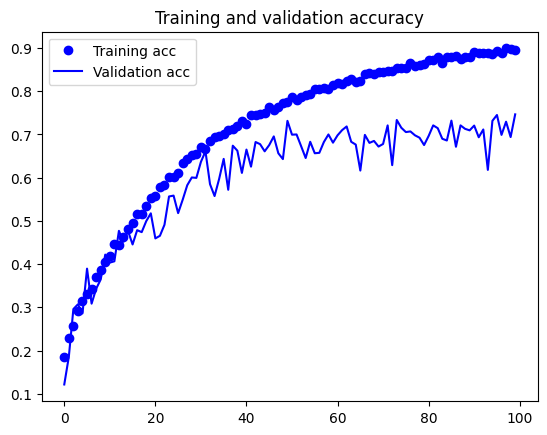

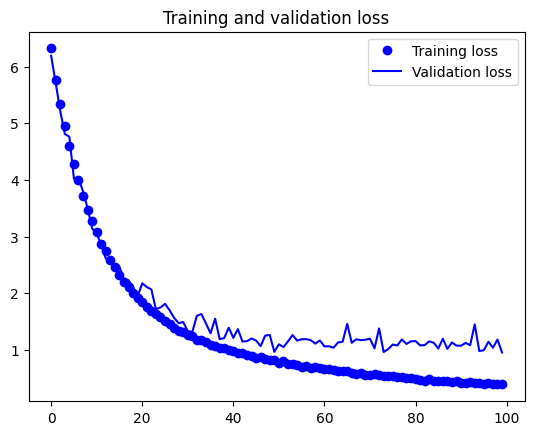

In [21]:
plotFromHistory(history_dropout1)

In [23]:
history_dropout1_2 = model23_1.fit(train_generator,
                              steps_per_epoch=235, #train_sample_size/data_batch_size
                              epochs=40,
                              validation_data=validation_generator,
                              validation_steps=63)

Epoch 1/40
235/235 [==============================] - 70s 298ms/step - loss: 0.3848 - acc: 0.8976 - val_loss: 1.1667 - val_acc: 0.7015
Epoch 2/40
235/235 [==============================] - 60s 254ms/step - loss: 0.3764 - acc: 0.8964 - val_loss: 1.2318 - val_acc: 0.6685
Epoch 3/40
235/235 [==============================] - 60s 255ms/step - loss: 0.3654 - acc: 0.9007 - val_loss: 0.9972 - val_acc: 0.7385
Epoch 4/40
235/235 [==============================] - 60s 254ms/step - loss: 0.3995 - acc: 0.8920 - val_loss: 1.0857 - val_acc: 0.7105
Epoch 5/40
235/235 [==============================] - 60s 255ms/step - loss: 0.3650 - acc: 0.9065 - val_loss: 1.0893 - val_acc: 0.7195
Epoch 6/40
235/235 [==============================] - 59s 253ms/step - loss: 0.3718 - acc: 0.8999 - val_loss: 1.1715 - val_acc: 0.7025
Epoch 7/40
235/235 [==============================] - 60s 255ms/step - loss: 0.3604 - acc: 0.9057 - val_loss: 1.3028 - val_acc: 0.6610
Epoch 8/40
235/235 [==============================] - 6

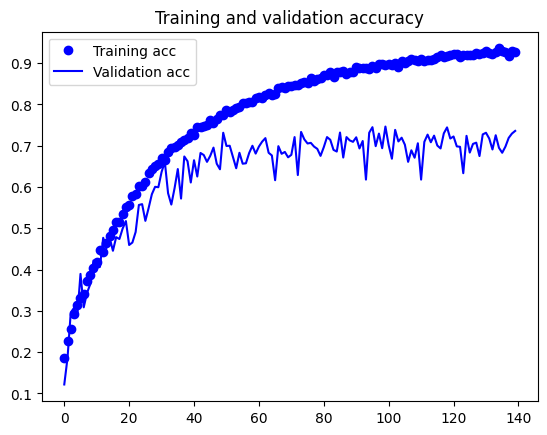

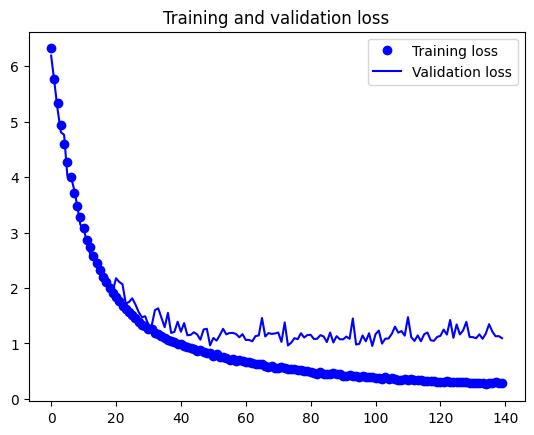

In [24]:
historyDropout1Com = type(history_dropout1)()  # Create an empty History object

# Concatenate the 'loss' and 'val_loss' lists
historyDropout1Com.history['acc'] = history_dropout1.history['acc'] + history_dropout1_2.history['acc']
historyDropout1Com.history['val_acc'] = history_dropout1.history['val_acc'] + history_dropout1_2.history['val_acc']
historyDropout1Com.history['loss'] = history_dropout1.history['loss'] + history_dropout1_2.history['loss']
historyDropout1Com.history['val_loss'] = history_dropout1.history['val_loss'] + history_dropout1_2.history['val_loss']
plotFromHistory(historyDropout1Com)

In [13]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras.layers import ZeroPadding2D, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.layers import SpatialDropout2D

img_size = 150

def createModelDropout(dropout=0.2):
    model15_8 = models.Sequential()

    model15_8.add(layers.Conv2D(64, (3, 3), activation='relu', 
                               input_shape=(img_size, img_size, 3),  kernel_regularizer=regularizers.l2(0.008)))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.Conv2D(64, (3, 3), activation='relu', 
                               input_shape=(img_size, img_size, 3), kernel_regularizer=regularizers.l2(0.008)))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.MaxPooling2D((2, 2)))
    model15_8.add(SpatialDropout2D(dropout))  # Add dropout layer

    model15_8.add(layers.Conv2D(128, (3, 3), activation='relu')) 
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.Conv2D(128, (3, 3), activation='relu')) 
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.MaxPooling2D((2, 2)))
    model15_8.add(SpatialDropout2D(dropout))  # Add dropout layer

    model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.MaxPooling2D((2, 2)))
    model15_8.add(SpatialDropout2D(dropout))  # Add dropout layer

    model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.MaxPooling2D((2, 2)))
    model15_8.add(SpatialDropout2D(dropout))  # Add dropout layer

    model15_8.add(ZeroPadding2D((1, 1)))
    model15_8.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model15_8.add(layers.MaxPooling2D((2, 2)))
    model15_8.add(SpatialDropout2D(dropout))  # Add dropout layer

    model15_8.add(layers.Flatten())
    model15_8.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0099)))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(Dropout(dropout))  # Add dropout layer
    model15_8.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0099)))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(Dropout(dropout))  # Add dropout layer
    model15_8.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0099)))
    model15_8.add(layers.Dense(10, activation='softmax'))

    model15_8.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.Adam(learning_rate=1.3*1e-4),
                      metrics=['acc'])

    model15_8.summary()
    return model15_8

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [33]:
model23_2 = createModelDropout(dropout=0.2)
model23_3 = createModelDropout(dropout=0.3)
model23_4 = createModelDropout(dropout=0.4)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 batch_normalization_48 (Ba  (None, 148, 148, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_45 (Conv2D)          (None, 146, 146, 64)      36928     
                                                                 
 batch_normalization_49 (Ba  (None, 146, 146, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 73, 73, 64)        0         
 ng2D)                                                           
                                                      

In [34]:
#pip install --upgrade tensorflow

In [35]:
history_dropout2 = model23_2.fit(train_generator,
                              steps_per_epoch=235, #train_sample_size/data_batch_size
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=63)

Epoch 1/100


2023-12-05 03:58:32.138479: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/spatial_dropout2d_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


235/235 [==============================] - 72s 266ms/step - loss: 6.4214 - acc: 0.1264 - val_loss: 6.1832 - val_acc: 0.0955
Epoch 2/100
235/235 [==============================] - 62s 264ms/step - loss: 5.9221 - acc: 0.1743 - val_loss: 5.6905 - val_acc: 0.1840
Epoch 3/100
235/235 [==============================] - 61s 261ms/step - loss: 5.5331 - acc: 0.1993 - val_loss: 5.3628 - val_acc: 0.2250
Epoch 4/100
235/235 [==============================] - 61s 261ms/step - loss: 5.1885 - acc: 0.2197 - val_loss: 4.9562 - val_acc: 0.2525
Epoch 5/100
235/235 [==============================] - 63s 269ms/step - loss: 4.8834 - acc: 0.2303 - val_loss: 4.7702 - val_acc: 0.2555
Epoch 6/100
235/235 [==============================] - 64s 272ms/step - loss: 4.5923 - acc: 0.2493 - val_loss: 4.3932 - val_acc: 0.2910
Epoch 7/100
235/235 [==============================] - 63s 266ms/step - loss: 4.3214 - acc: 0.2596 - val_loss: 4.0918 - val_acc: 0.3000
Epoch 8/100
235/235 [==============================] - 62s 2

In [36]:
history_dropout3 = model23_3.fit(train_generator,
                              steps_per_epoch=235, #train_sample_size/data_batch_size
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=63)

Epoch 1/100


2023-12-05 05:44:17.473397: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/spatial_dropout2d_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


235/235 [==============================] - 71s 263ms/step - loss: 6.5230 - acc: 0.1248 - val_loss: 6.3393 - val_acc: 0.1005
Epoch 2/100
235/235 [==============================] - 61s 259ms/step - loss: 6.0384 - acc: 0.1569 - val_loss: 5.8200 - val_acc: 0.1675
Epoch 3/100
235/235 [==============================] - 61s 260ms/step - loss: 5.6853 - acc: 0.1648 - val_loss: 5.3773 - val_acc: 0.2325
Epoch 4/100
235/235 [==============================] - 61s 261ms/step - loss: 5.3304 - acc: 0.1861 - val_loss: 5.1140 - val_acc: 0.2240
Epoch 5/100
235/235 [==============================] - 62s 263ms/step - loss: 5.0410 - acc: 0.1977 - val_loss: 4.7776 - val_acc: 0.2635
Epoch 6/100
235/235 [==============================] - 61s 258ms/step - loss: 4.7691 - acc: 0.2027 - val_loss: 4.5659 - val_acc: 0.2470
Epoch 7/100
235/235 [==============================] - 62s 265ms/step - loss: 4.5202 - acc: 0.2139 - val_loss: 4.2846 - val_acc: 0.2690
Epoch 8/100
235/235 [==============================] - 63s 2

In [37]:
history_dropout4 = model23_4.fit(train_generator,
                              steps_per_epoch=235, #train_sample_size/data_batch_size
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=63)

Epoch 1/100


2023-12-05 07:28:22.815998: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/spatial_dropout2d_25/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


235/235 [==============================] - 70s 259ms/step - loss: 6.6366 - acc: 0.1103 - val_loss: 6.2443 - val_acc: 0.0615
Epoch 2/100
235/235 [==============================] - 61s 260ms/step - loss: 6.1782 - acc: 0.1379 - val_loss: 5.8881 - val_acc: 0.1485
Epoch 3/100
235/235 [==============================] - 61s 259ms/step - loss: 5.8262 - acc: 0.1471 - val_loss: 5.5355 - val_acc: 0.1895
Epoch 4/100
235/235 [==============================] - 62s 264ms/step - loss: 5.5200 - acc: 0.1544 - val_loss: 5.2444 - val_acc: 0.2105
Epoch 5/100
235/235 [==============================] - 61s 260ms/step - loss: 5.2379 - acc: 0.1717 - val_loss: 5.0032 - val_acc: 0.2120
Epoch 6/100
235/235 [==============================] - 61s 261ms/step - loss: 4.9712 - acc: 0.1816 - val_loss: 4.7149 - val_acc: 0.2430
Epoch 7/100
235/235 [==============================] - 62s 264ms/step - loss: 4.7175 - acc: 0.1949 - val_loss: 4.4935 - val_acc: 0.2435
Epoch 8/100
235/235 [==============================] - 61s 2

In [5]:
def unpackPerformance(output, epoch):
    lines = output.split('\n')
    epochs = []
    loss_values = []
    acc = []
    val_loss_values = []
    val_acc = []

    for line in lines:
        words = line.split()
        if "loss" in line:
            loss_values.append(float(words[7]))
            acc.append(float(words[10]))
            val_loss_values.append(float(words[13]))
            val_acc.append(float(words[16]))

    epochs = [i for i in range(1, epoch+1)]
    return epochs, loss_values, acc, val_loss_values, val_acc

import matplotlib.pyplot as plt

def plot_single_metric(epochs, values, metric_name, ylabel, model_labels):
    for i, model_label in enumerate(model_labels):
        plt.plot(epochs[i], values[i], label=f'{model_label} {metric_name}', linestyle='-')
    plt.title(f'{metric_name} for Multiple Models')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
epochs0, loss_values0, acc0, val_loss_values0, val_acc0 = unpackPerformance(strDropout0, 100)
epochs1, loss_values1, acc1, val_loss_values1, val_acc1 = unpackPerformance(strDropout1, 100)
epochs2, loss_values2, acc2, val_loss_values2, val_acc2 = unpackPerformance(strDropout2, 100)
epochs3, loss_values3, acc3, val_loss_values3, val_acc3 = unpackPerformance(strDropout3, 100)
#epochs4, loss_values4, acc4, val_loss_values4, val_acc4 = unpackPerformance(reg4, 100)

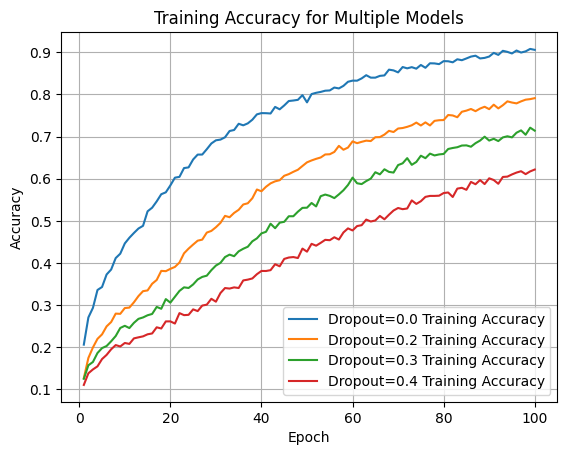

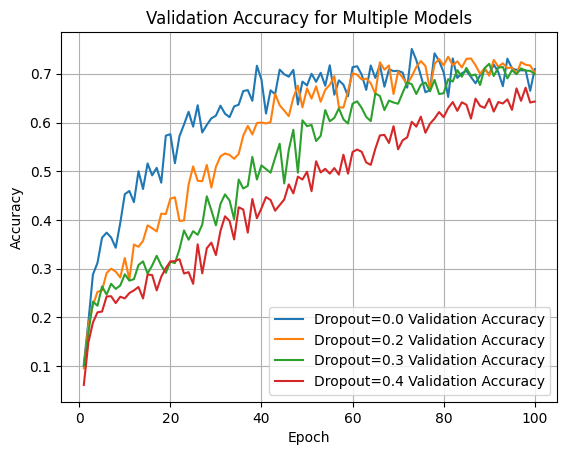

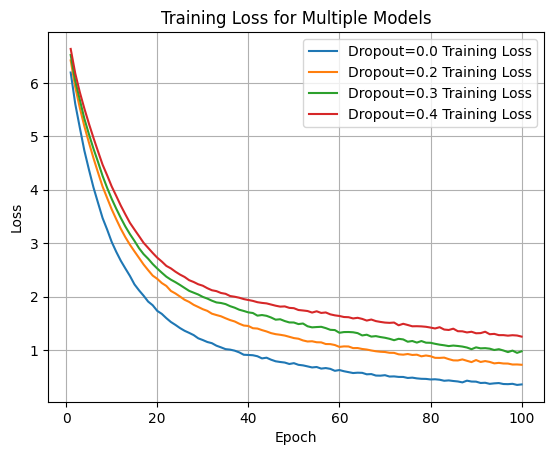

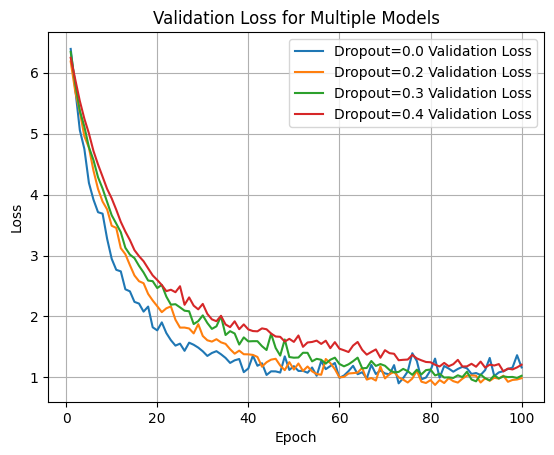

In [12]:
plot_single_metric([epochs0, epochs1, epochs2, epochs3], [acc0, acc1, acc2, acc3], 'Training Accuracy', 'Accuracy', ['Dropout=0.0', 'Dropout=0.2', 'Dropout=0.3', 'Dropout=0.4'])
plot_single_metric([epochs0, epochs1, epochs2, epochs3], [val_acc0, val_acc1, val_acc2, val_acc3], 'Validation Accuracy', 'Accuracy', ['Dropout=0.0', 'Dropout=0.2', 'Dropout=0.3', 'Dropout=0.4'])
plot_single_metric([epochs0, epochs1, epochs2, epochs3], [loss_values0, loss_values1, loss_values2, loss_values3], 'Training Loss', 'Loss', ['Dropout=0.0', 'Dropout=0.2', 'Dropout=0.3', 'Dropout=0.4'])
plot_single_metric([epochs0, epochs1, epochs2, epochs3], [val_loss_values0, val_loss_values1, val_loss_values2, val_loss_values3], 'Validation Loss', 'Loss', ['Dropout=0.0', 'Dropout=0.2', 'Dropout=0.3', 'Dropout=0.4'])

In [35]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras.layers import ZeroPadding2D, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.layers import SpatialDropout2D

img_size = 150

def createModelDropout(dropout=0.2):
    model15_8 = models.Sequential()

    model15_8.add(layers.Conv2D(64, (3, 3), activation='relu', 
                               input_shape=(img_size, img_size, 3),  kernel_regularizer=regularizers.l2(0.0001)))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.Conv2D(64, (3, 3), activation='relu', 
                               input_shape=(img_size, img_size, 3), kernel_regularizer=regularizers.l2(0.0001)))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.MaxPooling2D((2, 2)))
    model15_8.add(SpatialDropout2D(dropout))  # Add dropout layer

    model15_8.add(layers.Conv2D(128, (3, 3), activation='relu')) 
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.Conv2D(128, (3, 3), activation='relu')) 
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.MaxPooling2D((2, 2)))
    model15_8.add(SpatialDropout2D(dropout))  # Add dropout layer

    model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.MaxPooling2D((2, 2)))
    model15_8.add(SpatialDropout2D(dropout))  # Add dropout layer

    model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(layers.MaxPooling2D((2, 2)))
    model15_8.add(SpatialDropout2D(dropout))  # Add dropout layer

    model15_8.add(ZeroPadding2D((1, 1)))
    model15_8.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model15_8.add(layers.MaxPooling2D((2, 2)))
    model15_8.add(SpatialDropout2D(dropout))  # Add dropout layer

    model15_8.add(layers.Flatten())
    model15_8.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(Dropout(dropout))  # Add dropout layer
    model15_8.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model15_8.add(layers.BatchNormalization())
    model15_8.add(Dropout(dropout))  # Add dropout layer
    model15_8.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model15_8.add(layers.Dense(10, activation='softmax'))

    model15_8.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.Adam(learning_rate=1.7*1e-4),
                      metrics=['acc'])

    model15_8.summary()
    return model15_8

In [36]:
model23_5 = createModelDropout(dropout=0.3)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 batch_normalization_48 (Ba  (None, 148, 148, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_45 (Conv2D)          (None, 146, 146, 64)      36928     
                                                                 
 batch_normalization_49 (Ba  (None, 146, 146, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 73, 73, 64)        0         
 ng2D)                                                           
                                                      

In [38]:
history_dropout5 = model23_5.fit(train_generator,
                              steps_per_epoch=235, #train_sample_size/data_batch_size
                              epochs=140,
                              validation_data=validation_generator,
                              validation_steps=63)

Epoch 1/140
235/235 [==============================] - 98s 415ms/step - loss: 2.4222 - acc: 0.1361 - val_loss: 2.5864 - val_acc: 0.0865
Epoch 2/140
235/235 [==============================] - 69s 292ms/step - loss: 2.3344 - acc: 0.1748 - val_loss: 2.3719 - val_acc: 0.1480
Epoch 3/140
235/235 [==============================] - 69s 292ms/step - loss: 2.3086 - acc: 0.1760 - val_loss: 2.1779 - val_acc: 0.2205
Epoch 4/140
235/235 [==============================] - 70s 299ms/step - loss: 2.2601 - acc: 0.1836 - val_loss: 2.1898 - val_acc: 0.2295
Epoch 5/140
235/235 [==============================] - 73s 309ms/step - loss: 2.2351 - acc: 0.1972 - val_loss: 2.1214 - val_acc: 0.2495
Epoch 6/140
235/235 [==============================] - 71s 302ms/step - loss: 2.2223 - acc: 0.2119 - val_loss: 2.0845 - val_acc: 0.2680
Epoch 7/140
235/235 [==============================] - 70s 297ms/step - loss: 2.2027 - acc: 0.2159 - val_loss: 2.0788 - val_acc: 0.2705
Epoch 8/140
235/235 [===========================